In [205]:
import numpy as np
import scipy
from scipy.io import loadmat
import pandas as pd

from imageio import imread
import cv2
import matplotlib.pyplot as plt

import torch

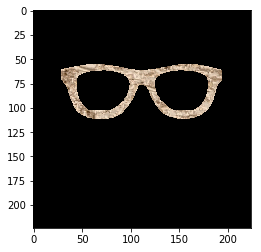

In [220]:
plt.imshow(warp_glasses.apply(torch.tensor(glasses), np.identity(3), photo.shape[:-1][::-1]).numpy())

In [289]:
from skimage import measure

N_MARKS = 7

def find_green_marks(image, draw_masks=False):
    # mask the green
    minus_red_mask = (image[:,:, 1].astype(np.int8) - image[:,:, 0].astype(np.int8)) > 19
    minus_blue_mask = (image[:,:, 1].astype(np.int8) - image[:,:, 2].astype(np.int8)) > 34
    red_mask = image[:, :, 0] < 180
    blue_mask = image[:, :, 2] < 185
    green_mask = image[:, :, 1] > 65
    masks = [minus_red_mask, minus_blue_mask, red_mask, blue_mask, green_mask]
    if draw_masks:
        for mask in masks:
            plt.imshow(mask, cmap='gray')
            plt.show()
    
    final_mask = np.ones(image.shape[:-1])
    for mask in masks:
        final_mask = np.logical_and(final_mask, mask)

    # erosion and dilation
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(final_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    if draw_masks:
        plt.imshow(opening, cmap='gray')
        plt.show()
    
    # label connected components
    labels = measure.label(opening, neighbors=8, background=0)

    label_masks = []
    areas = []

    for label in np.unique(labels):
        # if this is the background label, ignore it
        if not label:
            continue

        label_mask = np.zeros(opening.shape, dtype="uint8")
        label_mask[labels == label] = 1
        area = label_mask.sum()

        label_masks.append(label_mask)
        areas.append(area)
        
    # find coordinates of N_MARKS largest blobs
    if len(areas) < N_MARKS:
        print('not enough blobs to segment')
        return None

    areas = np.array(areas)
    biggest_blobs = np.array(label_masks)[areas.argsort()[-N_MARKS:][::-1]]
    coords = []
    for i in range(N_MARKS):
        blob = biggest_blobs[i]
        M = cv2.moments(blob)

        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        coords.append([cX, cY])
    coords = np.array(coords)
    
    # sort coordinates
    upper_mask = coords[:, 1] < np.percentile(coords[:, 1], 42)
    lower_mask = coords[:, 1] >= np.percentile(coords[:, 1], 42)

    upper_coords = coords[upper_mask]
    lower_coords = coords[lower_mask]

    sorted_coords = np.concatenate((upper_coords[upper_coords[:, 0].argsort()], lower_coords[lower_coords[:, 0].argsort()]), axis=0)
    return sorted_coords / np.array(image.shape[:-1][::-1])

In [298]:
import copy

def align_marks(glasses, green_marks_centers, eyeglass_marks_centers, out_shape):
    homo_matrix, _ = cv2.findHomography(eyeglass_marks_centers, green_marks_centers)#, method=cv2.CV_RANSAC)
    res_img = cv2.warpPerspective(glasses, homo_matrix, dsize=out_shape)#, borderMode=cv2.BORDER_REPLICATE)
    plt.imshow(res_img)
    plt.show()
    print(homo_matrix)
    inv_img = cv2.warpPerspective(res_img, homo_matrix, dsize=glasses.shape[:-1], flags=cv2.WARP_INVERSE_MAP)
    #plt.imshow(inv_img)
    #plt.show()
    return res_img

def wear_glasses(photo, glasses, green_marks_centers, eyeglass_marks_centers):
    aligned_glasses = align_marks(glasses, green_marks_centers, eyeglass_marks_centers, photo.shape[:-1][::-1])
    #print(aligned_glasses.shape)
    #print(photo.shape[:-1])
    wearing = copy.deepcopy(photo)
    wearing[aligned_glasses != 0] = aligned_glasses[aligned_glasses != 0]
    return wearing

def show_wearing(photo_path, glasses_path, green_marks_path=None):
    photo = imread(photo_path)
    if green_marks_path is not None:
        green_marks_centers = np.loadtxt(green_marks_path, delimiter=',')
    else:
        green_marks_centers = find_green_marks(photo)
    glasses = imread(glasses_path)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(photo)
    ax[0].scatter(green_marks_centers[:, 0], green_marks_centers[:, 1], marker='*', c='red', s=90)
    ax[0].axis('off')
    ax[1].imshow(wear_glasses(photo, glasses, green_marks_centers, eyeglass_marks_centers))
    ax[1].axis('off')
    plt.show()

    
eyeglass_marks_centers = loadmat('agns/data/auxiliary/eyeglass_marks_centers.mat')['eyeglass_marks_centers']
eyeglass_marks_centers[4] -= 12
eyeglass_marks_centers[0][1] += 1
eyeglass_marks_centers[2][1] += 1

np.savetxt('eyeglass_marks_centers.csv', eyeglass_marks_centers, delimiter=',')

eyeglass_marks_centers = np.loadtxt('eyeglass_marks_centers.csv', delimiter=',')

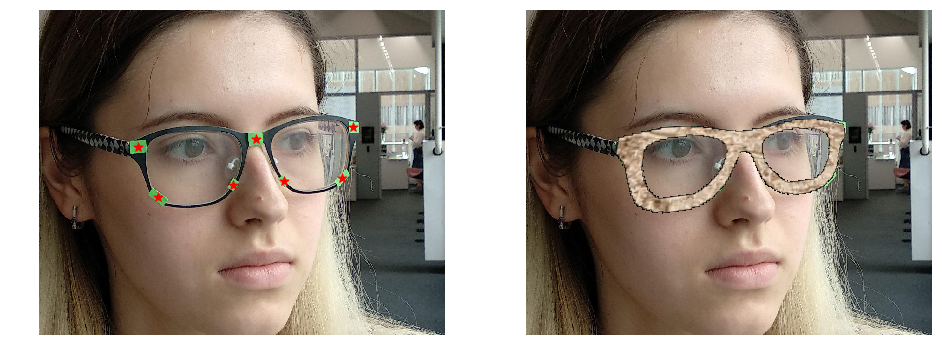

In [229]:
show_wearing('IMG_20190530_155411_cropped_0.jpg', 'agns/data/eyeglasses/glasses012930-2.png')

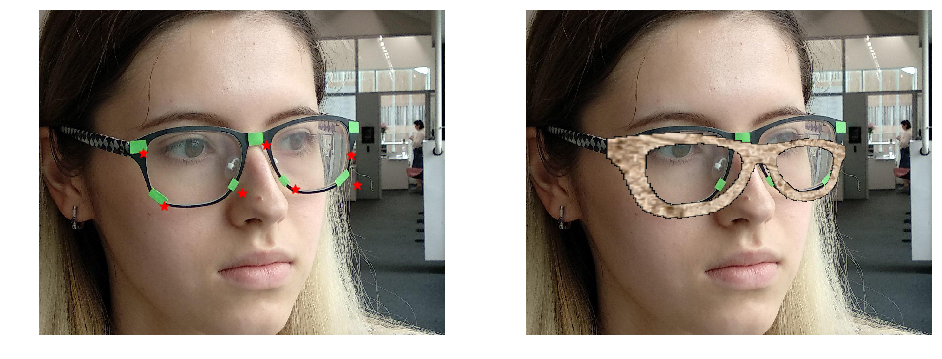

In [238]:
show_wearing('IMG_20190530_155411_cropped_0.jpg', 'agns/data/eyeglasses/glasses012930-2.png', 'IMG_20190530_155411_cropped_0.csv')

In [176]:
eyeglass_marks_centers = loadmat('agns/data/auxiliary/eyeglass_marks_centers.mat')['eyeglass_marks_centers']

eyeglass_marks_centers[4] -= 12
eyeglass_marks_centers[0][1] += 1
eyeglass_marks_centers[2][1] += 1

IMG_20190530_175912_cropped_1.jpg
not enough blobs to segment
Couldn't find enough blobs
IMG_20190530_175852_cropped_0.jpg
[[ 8.81646854e-01 -1.77085404e-01  1.60178380e+01]
 [ 2.30920930e-02  7.71247168e-01  1.51943333e+01]
 [ 5.18344048e-04 -1.52914435e-03  1.00000000e+00]]


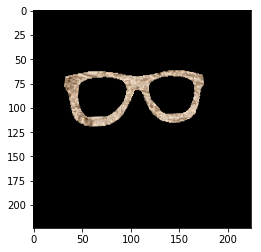

[[ 8.81646854e-01 -1.77085404e-01  1.60178380e+01]
 [ 2.30920930e-02  7.71247168e-01  1.51943333e+01]
 [ 5.18344048e-04 -1.52914435e-03  1.00000000e+00]]


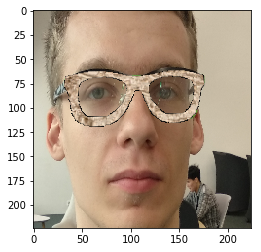

IMG_20190530_155408_cropped_0.jpg
[[ 4.68854743e-01  4.11712693e-02  5.28370669e+00]
 [-1.58567457e-01  7.20977148e-01  3.55389946e+01]
 [-1.28233522e-03 -5.26317870e-04  1.00000000e+00]]


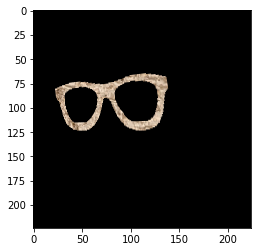

[[ 4.68854743e-01  4.11712693e-02  5.28370669e+00]
 [-1.58567457e-01  7.20977148e-01  3.55389946e+01]
 [-1.28233522e-03 -5.26317870e-04  1.00000000e+00]]


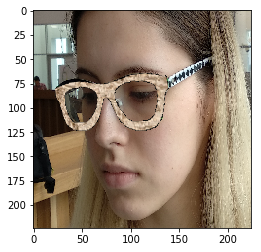

IMG_20190530_175716_cropped_0.jpg
[[ 7.78834986e-01 -1.69298920e-01  1.71484853e+01]
 [-1.90855387e-02  6.89543397e-01  2.31834387e+01]
 [ 6.88623939e-05 -1.44508594e-03  1.00000000e+00]]


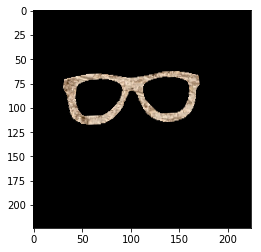

[[ 7.78834986e-01 -1.69298920e-01  1.71484853e+01]
 [-1.90855387e-02  6.89543397e-01  2.31834387e+01]
 [ 6.88623939e-05 -1.44508594e-03  1.00000000e+00]]


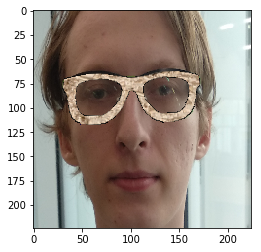

IMG_20190530_155810_cropped_0.jpg
not enough blobs to segment
Couldn't find enough blobs
IMG_20190530_155851_cropped_0.jpg
[[ 4.74897349e-01 -4.17598882e-02  4.78589871e+00]
 [-1.23152040e-01  7.42971542e-01  4.08921610e+01]
 [-1.14163177e-03 -5.65377507e-04  1.00000000e+00]]


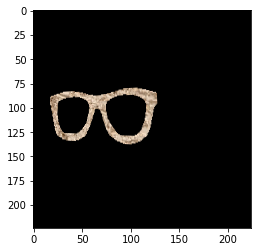

[[ 4.74897349e-01 -4.17598882e-02  4.78589871e+00]
 [-1.23152040e-01  7.42971542e-01  4.08921610e+01]
 [-1.14163177e-03 -5.65377507e-04  1.00000000e+00]]


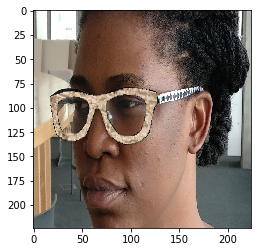

In [299]:
import os

def generate_wearing(img_dir, glasses_path, save_path):
    glasses = imread(glasses_path)
    for folder in os.listdir(img_dir):
        for file in os.listdir(f'{img_dir}/{folder}'):
            print(file)
            photo = imread(f'{img_dir}/{folder}/{file}')
            green_marks_centers = find_green_marks(photo)
            if green_marks_centers is not None:
                photo = cv2.resize(photo, (224, 224))
                new_green_marks_centers = green_marks_centers * 224
                #plt.imshow(photo)
                #plt.scatter(new_green_marks_centers[:, 0], new_green_marks_centers[:, 1], marker='*', c='red', s=90)
                #plt.show()
                homo_matrix, _ = cv2.findHomography(eyeglass_marks_centers, new_green_marks_centers)
                print(homo_matrix)
                name = file.split('.')[0]
                #np.savetxt(f"{save_path}/{folder}/{name}.csv", homo_matrix, delimiter=',')
                wearing = wear_glasses(photo, glasses, new_green_marks_centers, eyeglass_marks_centers)
                plt.imshow(wearing)
                plt.show()
                break
                #plt.imsave(f'{save_path}/{folder}/{file}', photo)
            else:
                print("Couldn't find enough blobs")
                wearing = photo
        
generate_wearing('photos/results3', 'agns/data/eyeglasses/glasses012930-2.png', 'physical_dataset_homo')

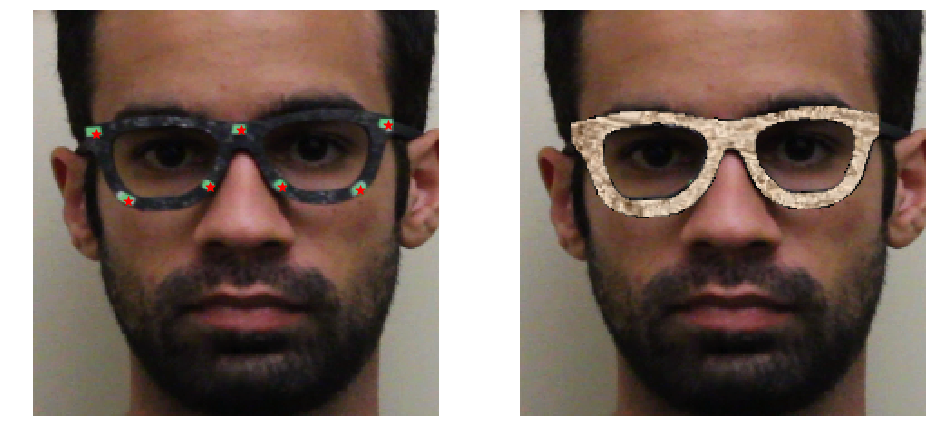

In [230]:
show_wearing('agns/data/demo-data2/aligned_vgg_ms6.png', 'agns/data/eyeglasses/glasses012930-2.png', 'aligned_vgg_ms6.csv')

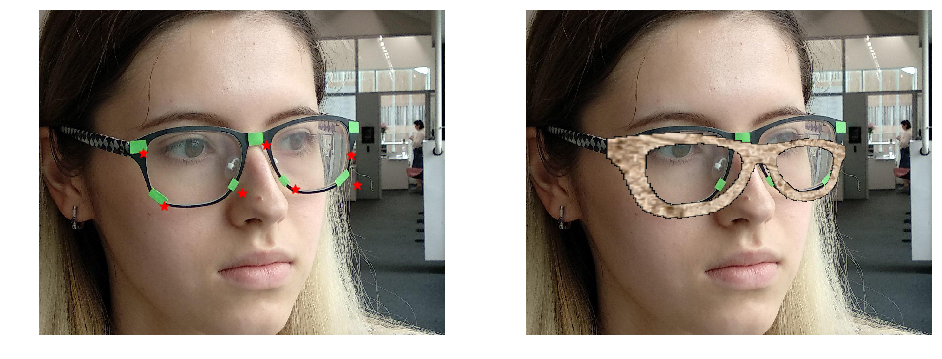

In [236]:
show_wearing('IMG_20190530_155411_cropped_0.jpg', 'agns/data/eyeglasses/glasses012930-2.png', 'IMG_20190530_155411_cropped_0.csv')

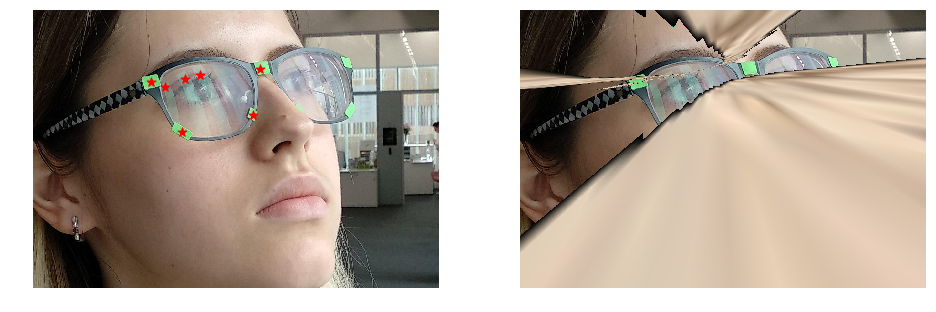

In [235]:
show_wearing('IMG_20190530_155413_cropped_0.jpg', 'agns/data/eyeglasses/glasses012930-2.png', 'IMG_20190530_155413_cropped_0.csv')

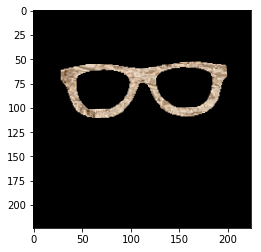

In [58]:
plt.imshow(aligned_glasses)

In [60]:
aligned_photo = photo
aligned_photo[aligned_glasses != 0] = aligned_glasses[aligned_glasses != 0]

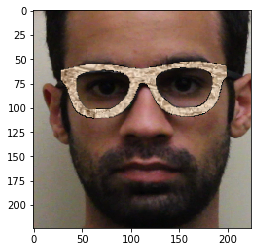

In [61]:
plt.imshow(aligned_photo)

In [ ]:
cv2.warpPerspective(glasses, )